Import libraries

In [147]:
# Data manipulation and file handling
import pandas as pd  # for data manipulation
import pyarrow.feather as feather  # for reading/writing Feather files

# Modeling and machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # example model
from sklearn.metrics import accuracy_score, classification_report  # evaluation metrics

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [148]:
# Open training 
df= pd.read_feather('../data/processed/train_data.feather')

In [149]:
# Open testing
tdf = pd.read_feather('../data/processed/test_data.feather')

In [150]:
df.head()

,searchDate,flightDate,startingAirport,destinationAirport,isNonStop,totalFare,totalTravelDistance,segmentsArrivalAirportCode,DepartureTimeHour,CabinCode,AirlineNameScore,date_diff_days,weekday
3767896,2022-04-18,2022-05-06,LGA,DFW,True,93.599998,1380.0,DFW,8,1.0,2,18,4
929418,2022-05-11,2022-05-18,BOS,IAD,False,207.600006,406.0,JFK||IAD,11,1.0,4,7,2
5456598,2022-05-08,2022-06-21,ORD,EWR,False,358.600006,725.0,DTW||EWR,14,1.0,4,44,1
4876708,2022-05-08,2022-05-18,OAK,BOS,False,728.599976,2688.0,SLC||BOS,17,1.0,4,10,2
2004101,2022-05-12,2022-07-01,DFW,ATL,True,228.600006,725.0,ATL,19,1.0,4,50,4


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5106602 entries, 3767896 to 1692743
Data columns (total 13 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   searchDate                  datetime64[ns]
 1   flightDate                  datetime64[ns]
 2   startingAirport             object        
 3   destinationAirport          object        
 4   isNonStop                   bool          
 5   totalFare                   float32       
 6   totalTravelDistance         float32       
 7   segmentsArrivalAirportCode  object        
 8   DepartureTimeHour           uint8         
 9   CabinCode                   float32       
 10  AirlineNameScore            uint8         
 11  date_diff_days              uint16        
 12  weekday                     uint8         
dtypes: bool(1), datetime64[ns](2), float32(3), object(3), uint16(1), uint8(3)
memory usage: 321.4+ MB


In [152]:
df.shape

(5106602, 13)

In [153]:

# Calculate average price per route
route_avg_price = (
    df.groupby(['startingAirport', 'destinationAirport'])['totalFare']
    .mean()
    .reset_index()
    .rename(columns={'totalFare': 'average_price'})
)

# Merge this back to the original dataset
data = df.merge(route_avg_price, on=['startingAirport', 'destinationAirport'], how='left')

In [154]:
data.head()

,searchDate,flightDate,startingAirport,destinationAirport,isNonStop,totalFare,totalTravelDistance,segmentsArrivalAirportCode,DepartureTimeHour,CabinCode,AirlineNameScore,date_diff_days,weekday,average_price
0,2022-04-18,2022-05-06,LGA,DFW,True,93.599998,1380.0,DFW,8,1.0,2,18,4,218.513184
1,2022-05-11,2022-05-18,BOS,IAD,False,207.600006,406.0,JFK||IAD,11,1.0,4,7,2,233.873978
2,2022-05-08,2022-06-21,ORD,EWR,False,358.600006,725.0,DTW||EWR,14,1.0,4,44,1,233.211212
3,2022-05-08,2022-05-18,OAK,BOS,False,728.599976,2688.0,SLC||BOS,17,1.0,4,10,2,597.794067
4,2022-05-12,2022-07-01,DFW,ATL,True,228.600006,725.0,ATL,19,1.0,4,50,4,260.961975


In [155]:
# Display a few sample rows with 'startingAirport', 'destinationAirport', 'totalFare', and 'average_price'
print(data[['startingAirport', 'destinationAirport', 'totalFare', 'average_price']].sample(10))


        startingAirport destinationAirport   totalFare  average_price
3630887             OAK                DEN  186.580002     321.297302
3059066             DEN                DTW  460.600006     361.510010
1765992             PHL                CLT  208.960007     259.660156
4076596             EWR                IAD  406.700012     291.370392
3489648             DFW                DTW  238.580002     326.230133
4705161             SFO                DEN  318.600006     385.038055
2362765             JFK                BOS  108.599998     189.345779
1997406             DFW                ATL  339.209991     260.961975
1000790             DEN                ORD  617.599976     352.601685
185500              LGA                ORD  162.100006     182.396484


In [156]:
# Step 3: Merge the same average price into the test set
# This will apply the training-set-based averages to the test set routes
tdf = tdf.merge(route_avg_price, on=['startingAirport', 'destinationAirport'], how='left')

In [157]:
tdf.head()

,searchDate,flightDate,startingAirport,destinationAirport,isNonStop,totalFare,totalTravelDistance,segmentsArrivalAirportCode,DepartureTimeHour,CabinCode,AirlineNameScore,date_diff_days,weekday,average_price
0,2022-05-02,2022-05-28,LAX,CLT,True,555.609985,2121.0,CLT,7,1.0,4,26,5,463.072906
1,2022-05-03,2022-06-21,DEN,CLT,False,394.200012,1800.0,IAD||CLT,23,1.0,4,49,1,390.585907
2,2022-05-06,2022-05-09,SFO,ORD,True,758.599976,1847.0,ORD,10,1.0,4,3,0,518.917725
3,2022-05-03,2022-05-17,LAX,DTW,False,338.589996,NaN,LAS||DTW,13,1.0,1,14,1,447.044220
4,2022-05-02,2022-06-13,SFO,DFW,True,308.600006,1468.0,DAL,9,1.0,4,42,0,394.781616


In [158]:
data.head()

,searchDate,flightDate,startingAirport,destinationAirport,isNonStop,totalFare,totalTravelDistance,segmentsArrivalAirportCode,DepartureTimeHour,CabinCode,AirlineNameScore,date_diff_days,weekday,average_price
0,2022-04-18,2022-05-06,LGA,DFW,True,93.599998,1380.0,DFW,8,1.0,2,18,4,218.513184
1,2022-05-11,2022-05-18,BOS,IAD,False,207.600006,406.0,JFK||IAD,11,1.0,4,7,2,233.873978
2,2022-05-08,2022-06-21,ORD,EWR,False,358.600006,725.0,DTW||EWR,14,1.0,4,44,1,233.211212
3,2022-05-08,2022-05-18,OAK,BOS,False,728.599976,2688.0,SLC||BOS,17,1.0,4,10,2,597.794067
4,2022-05-12,2022-07-01,DFW,ATL,True,228.600006,725.0,ATL,19,1.0,4,50,4,260.961975


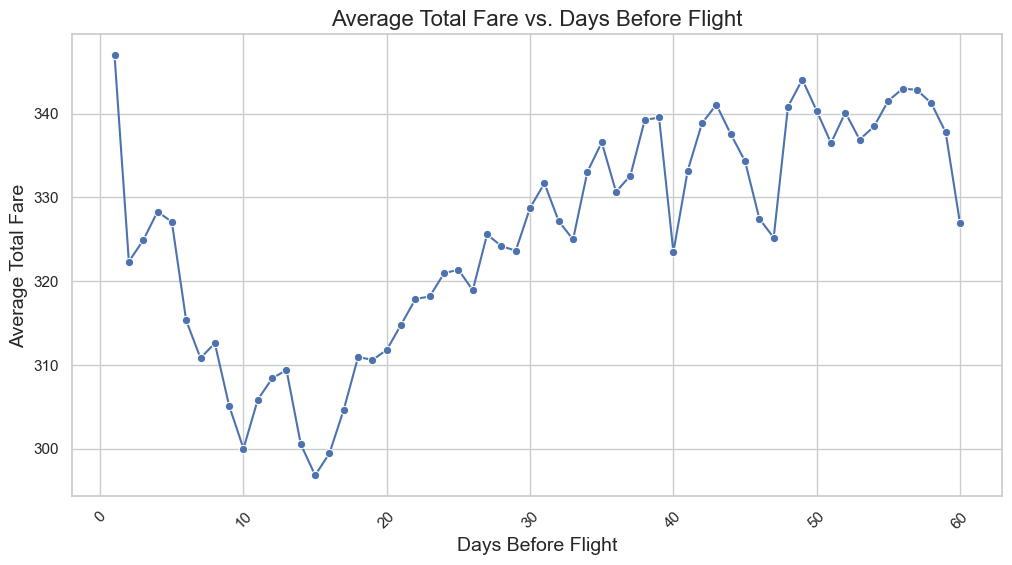

In [159]:
# Calculate average total fare by days before flight
avg_fare_by_days = data.groupby('date_diff_days')['totalFare'].mean().reset_index()

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_diff_days', y='totalFare', data=avg_fare_by_days, marker='o')
plt.title('Average Total Fare vs. Days Before Flight', fontsize=16)
plt.xlabel('Days Before Flight', fontsize=14)
plt.ylabel('Average Total Fare', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


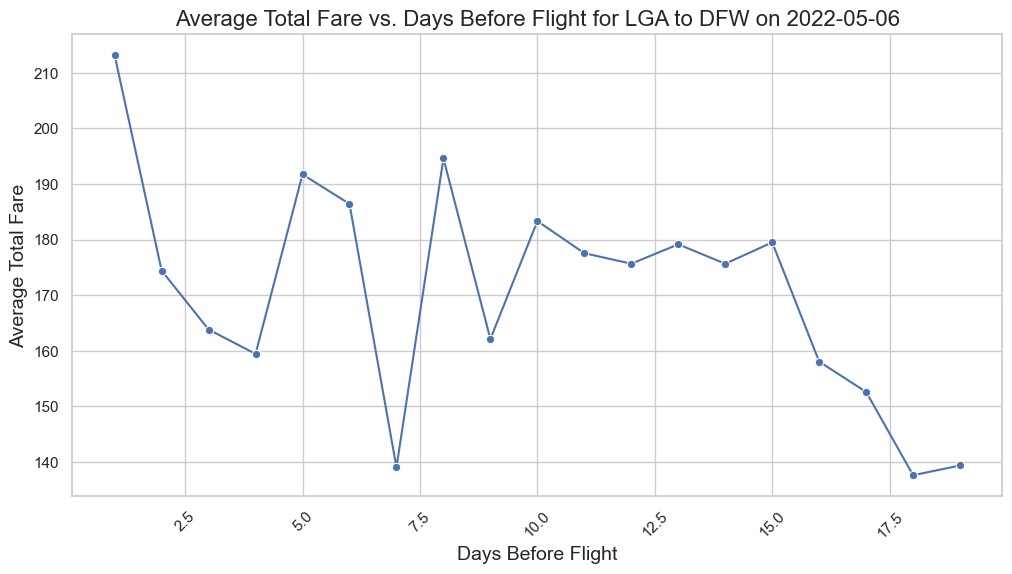

In [160]:
# Specify the criteria for a single flight
starting_airport = 'LGA'  # Change this to your desired starting airport
destination_airport = 'DFW'  # Change this to your desired destination airport
specific_flight_date = '2022-05-06'  # Change this to your desired flight date

# Filter the data for the specific flight
single_flight_data = data[(data['startingAirport'] == starting_airport) & 
                           (data['destinationAirport'] == destination_airport) & 
                           (data['flightDate'] == specific_flight_date)]

# Calculate average total fare by days before flight for this specific flight
avg_fare_by_days = single_flight_data.groupby('date_diff_days')['totalFare'].mean().reset_index()

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_diff_days', y='totalFare', data=avg_fare_by_days, marker='o')
plt.title(f'Average Total Fare vs. Days Before Flight for {starting_airport} to {destination_airport} on {specific_flight_date}', fontsize=16)
plt.xlabel('Days Before Flight', fontsize=14)
plt.ylabel('Average Total Fare', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


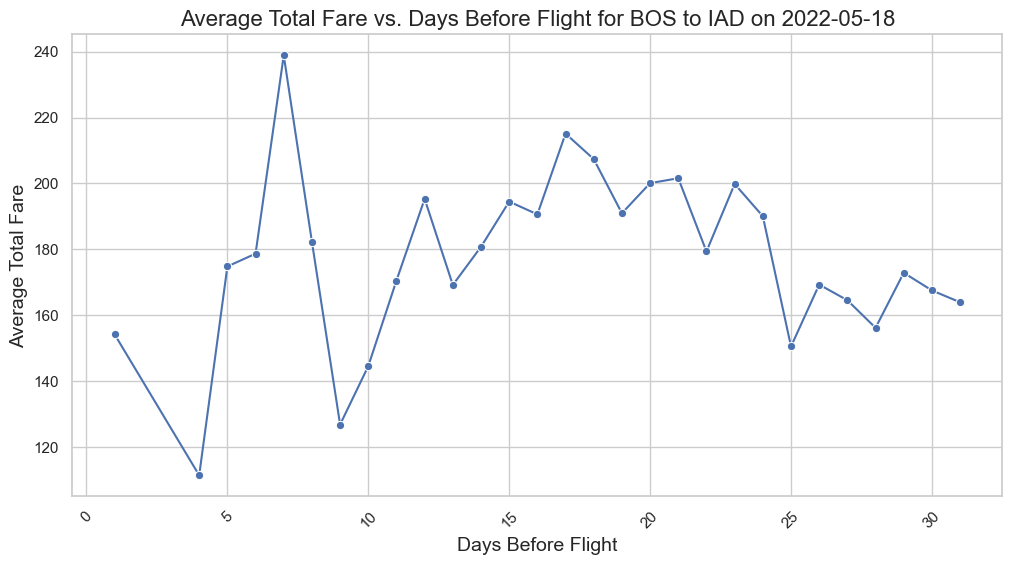

In [161]:
# Specify the criteria for another single flight
starting_airport = 'BOS'  # Change this to your desired starting airport
destination_airport = 'IAD'  # Change this to your desired destination airport
specific_flight_date = '2022-05-18'  # Change this to your desired flight date

# Filter the data for this specific flight
another_flight_data = data[(data['startingAirport'] == starting_airport) & 
                            (data['destinationAirport'] == destination_airport) & 
                            (data['flightDate'] == specific_flight_date)]

# Calculate average total fare by days before flight for this specific flight
avg_fare_by_days_another = another_flight_data.groupby('date_diff_days')['totalFare'].mean().reset_index()

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_diff_days', y='totalFare', data=avg_fare_by_days_another, marker='o')
plt.title(f'Average Total Fare vs. Days Before Flight for {starting_airport} to {destination_airport} on {specific_flight_date}', fontsize=16)
plt.xlabel('Days Before Flight', fontsize=14)
plt.ylabel('Average Total Fare', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [162]:
data.head()

,searchDate,flightDate,startingAirport,destinationAirport,isNonStop,totalFare,totalTravelDistance,segmentsArrivalAirportCode,DepartureTimeHour,CabinCode,AirlineNameScore,date_diff_days,weekday,average_price
0,2022-04-18,2022-05-06,LGA,DFW,True,93.599998,1380.0,DFW,8,1.0,2,18,4,218.513184
1,2022-05-11,2022-05-18,BOS,IAD,False,207.600006,406.0,JFK||IAD,11,1.0,4,7,2,233.873978
2,2022-05-08,2022-06-21,ORD,EWR,False,358.600006,725.0,DTW||EWR,14,1.0,4,44,1,233.211212
3,2022-05-08,2022-05-18,OAK,BOS,False,728.599976,2688.0,SLC||BOS,17,1.0,4,10,2,597.794067
4,2022-05-12,2022-07-01,DFW,ATL,True,228.600006,725.0,ATL,19,1.0,4,50,4,260.961975


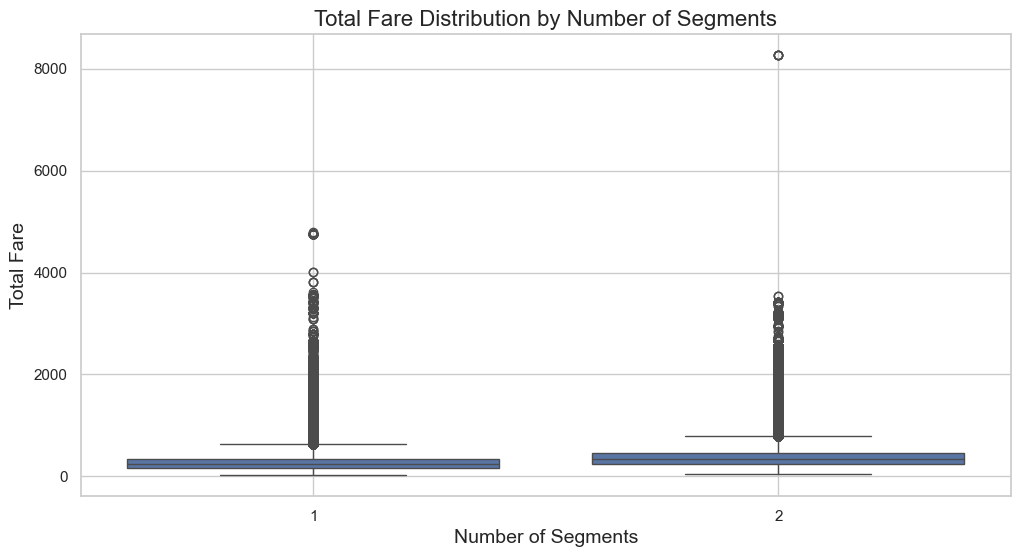

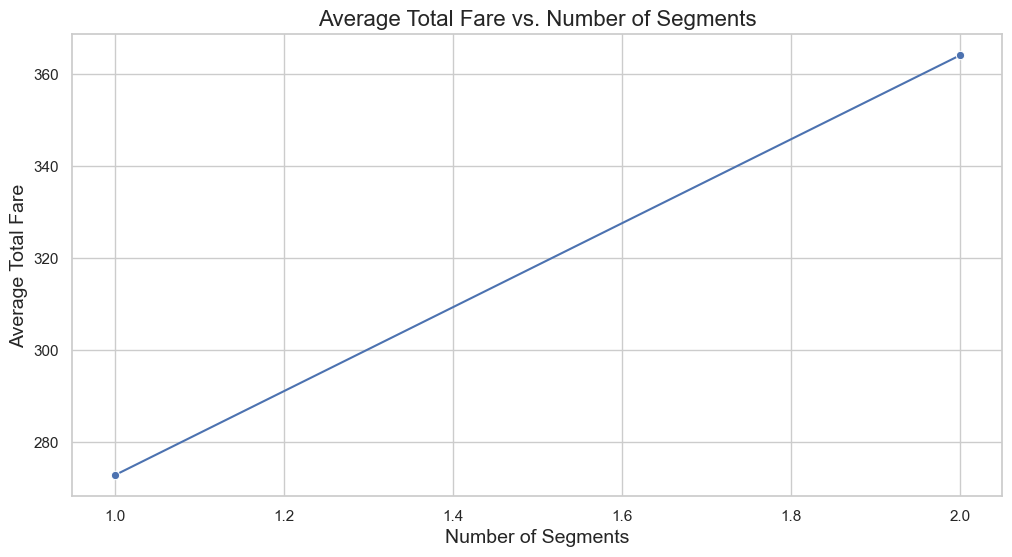

In [163]:
# Create a feature to count the number of segments
data['num_segments'] = data['segmentsArrivalAirportCode'].apply(lambda x: len(x.split('||')))

# Visualize the relationship between number of segments and total fare
plt.figure(figsize=(12, 6))
sns.boxplot(x='num_segments', y='totalFare', data=data)
plt.title('Total Fare Distribution by Number of Segments', fontsize=16)
plt.xlabel('Number of Segments', fontsize=14)
plt.ylabel('Total Fare', fontsize=14)
plt.grid(True)
plt.show()

# Optionally, calculate the average fare by number of segments
avg_fare_by_segments = data.groupby('num_segments')['totalFare'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='num_segments', y='totalFare', data=avg_fare_by_segments, marker='o')
plt.title('Average Total Fare vs. Number of Segments', fontsize=16)
plt.xlabel('Number of Segments', fontsize=14)
plt.ylabel('Average Total Fare', fontsize=14)
plt.grid(True)
plt.show()


In [164]:
data.head()

,searchDate,flightDate,startingAirport,destinationAirport,isNonStop,totalFare,totalTravelDistance,segmentsArrivalAirportCode,DepartureTimeHour,CabinCode,AirlineNameScore,date_diff_days,weekday,average_price,num_segments
0,2022-04-18,2022-05-06,LGA,DFW,True,93.599998,1380.0,DFW,8,1.0,2,18,4,218.513184,1
1,2022-05-11,2022-05-18,BOS,IAD,False,207.600006,406.0,JFK||IAD,11,1.0,4,7,2,233.873978,2
2,2022-05-08,2022-06-21,ORD,EWR,False,358.600006,725.0,DTW||EWR,14,1.0,4,44,1,233.211212,2
3,2022-05-08,2022-05-18,OAK,BOS,False,728.599976,2688.0,SLC||BOS,17,1.0,4,10,2,597.794067,2
4,2022-05-12,2022-07-01,DFW,ATL,True,228.600006,725.0,ATL,19,1.0,4,50,4,260.961975,1


In [165]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Assuming 'data' is your DataFrame with all relevant features
# Select features
features = ['totalTravelDistance', 'date_diff_days', 'average_price','AirlineNameScore' ,'weekday',
            'startingAirport', 'destinationAirport', 'isNonStop', 'CabinCode']

X = data[features]
y = data['totalFare']

# Define categorical and numerical columns
categorical_cols = ['startingAirport', 'destinationAirport']
numerical_cols = ['CabinCode','totalTravelDistance', 'date_diff_days', 'average_price','AirlineNameScore' ,'weekday']

# Create transformers for both types of columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardize numerical features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Prepare the final dataset
X_preprocessed = preprocessor.fit_transform(X)




In [166]:
# Now, prepare the test data
X_test = tdf[features]  # Use the same features as the training set
# Transform the test data using the already fitted preprocessor
X_test_preprocessed = preprocessor.transform(X_test)

In [138]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_preprocessed, y)

# Step 2: Make predictions on the test set
y_pred = model.predict(X_test_preprocessed)

# Step 3: Calculate RMSE
rmse = np.sqrt(mean_squared_error(tdf['totalFare'], y_pred))  # Assuming 'totalFare' is the true target in tdf
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


Root Mean Squared Error (RMSE): 105.80


In [168]:
import joblib

# Save model to a file
joblib.dump(model, '../models/xgboost_model.joblib')

# To load the model back later
#model = joblib.load('xgboost_model.joblib')


['../models/xgboost_model.joblib']

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import lime
import lime.lime_tabular

def evaluate_models(models, X_train, y_train, X_test, y_test, is_classification=False):
    """
    Evaluate the performance of different models.
    
    Parameters:
    - models: dict, a dictionary of models with their names as keys and model instances as values.
    - X_train: DataFrame, training features.
    - y_train: Series, training target.
    - X_test: DataFrame, testing features.
    - y_test: Series, testing target.
    - is_classification: bool, True if models are classification models, False if regression.
    
    Returns:
    - results_df: DataFrame containing model performance metrics and feature importance.
    """
    results = []
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        
        # Make predictions and calculate performance metric
        if is_classification:
            predictions = model.predict(X_test)
            performance_metric = accuracy_score(y_test, predictions)
        else:
            predictions = model.predict(X_test)
            performance_metric = np.sqrt(mean_squared_error(y_test, predictions))
        
        # Calculate permutation importance
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
        feature_importance = perm_importance.importances_mean
        
        # Store results
        results.append({
            'Model': model_name,
            'Performance Metric': performance_metric,
            'Feature Importance': feature_importance
        })
    
    results_df = pd.DataFrame(results)
    return results_df

def explain_with_lime(model, X_train, X_test, feature_names):
    """
    Explain predictions using LIME.
    
    Parameters:
    - model: the trained model to explain.
    - X_train: DataFrame, training features.
    - X_test: DataFrame, testing features to explain.
    - feature_names: list of feature names.
    """
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=feature_names,
        mode='regression' if model.__class__.__name__ in ['XGBRegressor', 'MLPRegressor'] else 'classification'
    )
    
    for i in range(len(X_test)):
        exp = explainer.explain_instance(X_test.iloc[i].values, model.predict)
        exp.show_in_notebook(show_table=True)

def plot_partial_dependence(model, X, feature_names):
    """
    Plot Partial Dependence Plots (PDP).
    
    Parameters:
    - model: the trained model to analyze.
    - X: DataFrame, features.
    - feature_names: list of feature names.
    """
    display = PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=feature_names,
        grid_resolution=50
    )
    plt.show()

def model_eval(models, X_train, y_train, X_test, y_test, feature_names, is_classification=False):
    """
    Comprehensive evaluation of models including performance metrics and interpretability.
    
    Parameters:
    - models: dict, dictionary of models.
    - X_train, y_train: training data.
    - X_test, y_test: testing data.
    - feature_names: list of feature names for interpretability.
    - is_classification: bool, True if classification models.
    """
    # Evaluate models and get results
    results_df = evaluate_models(models, X_train, y_train, X_test, y_test, is_classification)
    return results_df  # Return results without printing

# Individual calls for evaluation, explanation, and plotting
def run_evaluation(models, X_train, y_train, X_test, y_test, feature_names, is_classification=False):
    results_df = model_eval(models, X_train, y_train, X_test, y_test, feature_names, is_classification)
    print("Model Evaluation Results:")
    print(results_df)

def run_lime_explanation(model, X_train, X_test, feature_names):
    print("\nLIME Explanations:")
    explain_with_lime(model, X_train, X_test, feature_names)

def run_partial_dependence(model, X, feature_names):
    print("\nPartial Dependence Plots:")
    plot_partial_dependence(model, X, feature_names)


In [146]:
# Create a dictionary of models
models = {
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    # Add other models if necessary
}

# Specify feature names for interpretability
feature_names = ['totalTravelDistance', 'date_diff_days', 'average_price', 'AirlineNameScore', 'weekday', 
                 'startingAirport', 'destinationAirport', 'isNonStop', 'CabinCode']

# Call the evaluation function
run_evaluation(models, X_preprocessed, y, X_test_preprocessed, tdf['totalFare'], feature_names, is_classification=False)

# Get the first model for LIME explanations and partial dependence plotting
first_model = list(models.values())[0]

# Call LIME explanation
#run_lime_explanation(first_model, X_preprocessed, X_test_preprocessed, feature_names)

# Call Partial Dependence Plotting
run_partial_dependence(first_model, X_test_preprocessed, feature_names)


Model Evaluation Results:
     Model  Performance Metric  \
0  XGBoost          105.796814   

                                  Feature Importance  
0  [0.2715182522932688, 2.6165627956390383, 0.051...  

Partial Dependence Plots:


ValueError: Feature 'totalTravelDistance' not in feature_names